In [1]:
import sys
import os

# Adjust this path to point to the root of your project (the one containing `src/`)
project_root = os.path.abspath("..")  # or "../../" depending on where notebook is
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import gpflow
from gpflow.base import _cast_to_dtype
import tensorflow as tf
import numpy as np
from gpflow.config import default_float
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch
import pathlib as pl
import os
from src.lvmogp.lvmogp_test_functions import TestFun

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

C:\Users\mtret\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mtret\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
import torch
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch      
from src.gp_dataclasses  import GPSSVIConfig
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Quick Notebook Showing how to fit the LVMOGP

In [22]:
seed=1
surface_type = 'linear_relation'
n_new_points=5
n_new_funs = 10
data_type_name = f'two_observed_{n_new_funs}_new'
n_fun = 2 + n_new_funs
total_train = 30*2 + 3 * n_new_points
n_points = [10]*2 + [n_new_points]*n_new_funs
n_train = n_points

set_opt_seed = False

same_points = False
plot_figs = True

train_inducing = True
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
max_points = 60

noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]
lengthscales_h = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4][:latent_dims]


test_fun = TestFun(domain=domain, seed=seed, n_fun=n_fun,
                   observed_dims=observed_dims, test_type=surface_type, latent_dims=latent_dims, max_points=max_points,
                   noise=noise, n_grid_points=n_grid_points, same_points=same_points, lengthscales_X=lengthscales_x,
                   lengthscales_H=lengthscales_h)

## Generate and Plot the Data

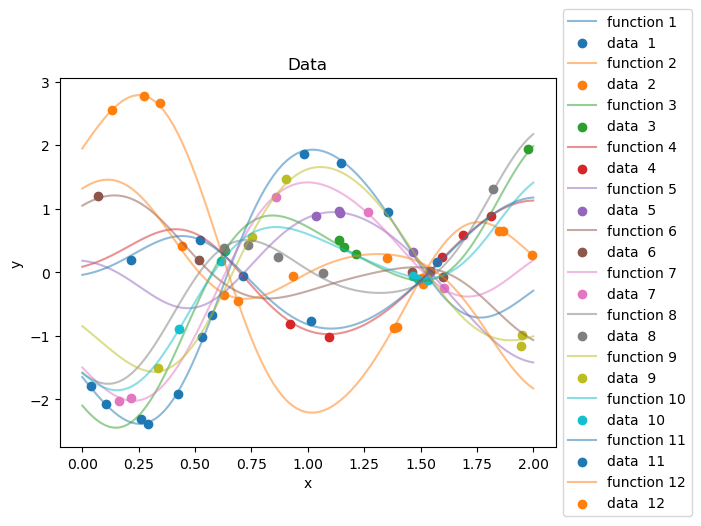

In [23]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)


if plot_figs:
    test_fun.plot_data(n_points)

## Fit the LVMOGP

Randomly initialise the hyperparameters

In [24]:
torch.set_default_dtype(torch.float64)

# random H initialisation (unchanged values, just Torch)
H_mean = torch.tensor(
    np.random.uniform(-1, 1, (n_fun, latent_dims_lvmogp)),
    dtype=torch.float64
)
H_var  = torch.full_like(H_mean, 1e-6)

# likelihood noise (same formula as before)
lik_variance = np.var(data_y) * 0.01
n_u          =  min(200, len(data_X))                     # number of inducing inputs

Make the LVMOGP

In [25]:
Y_torch  = torch.tensor(data_y , dtype=torch.float64)
X_torch  = torch.tensor(data_X , dtype=torch.float64)
fn_torch = torch.tensor(fun_nos, dtype=torch.float64)

# H_mean = (n_fun, Q)
H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)
H_var_all  = torch.full_like(H_mean_all, 1e-6)

model = LVMOGP_SSVI_Torch(
    data        = Y_torch,
    X_data      = X_torch,
    X_data_fn   = fn_torch,
    H_data_mean = H_mean_all,
    H_data_var  = H_var_all,
    num_inducing_variables = n_u,
)


C:\Users\mtret\AppData\Local\Temp\ipykernel_47648\4154977831.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)


In [26]:
from src.gp_dataclasses import (
    GPSSVIConfig,
    LR,
    Rho,
    Training,
    InnerIters,
    InducingConfig,
    InitXDistSsvi,
)


cfg = GPSSVIConfig(
    device="cpu",                    # или "auto"
    debug=False,
    jitter=5e-6,
    max_exp=60.0,
    q_latent=latent_dims_lvmogp,
    init_signal_to_noise_ratio=1.0,
    num_u_samples_per_iter=2,

    lr=LR(
        x=1e-3,
        hyp=1e-3,
        alpha=5e-3,
    ),

    rho=Rho(
        t0=100.0,
        k=0.6,
    ),

    training=Training(
        batch_size=min(128, len(data_X)),
        total_iters=100,
        inner_iters=InnerIters(
            start=40,
            after=30,
            switch=50,
        ),
    ),

    inducing=InducingConfig(
        n_inducing=n_u,
        selection="perm",
        seed=19,
    ),

    init_latent_dist=InitXDistSsvi(
        method="default",
        custom_path=None,
    ),
)


Train it

In [27]:
results = model.ssvi_train(cfg)          # trains in Torch

Config auto selected device: cpu
num_u_samples_per_iter: 2
snr: 1.0


  1%|▋                                                              | 1/100 [00:02<03:20,  2.03s/it]


DATASET FULL ELBO @   1: -1.1569e+03  LL=-1.1022e+02  KL_X=6.4979e+02  KL_U=3.9693e+02


  2%|█▎                                                             | 2/100 [00:03<03:06,  1.90s/it]


DATASET FULL ELBO @   2: -9.2108e+02  LL=-1.0871e+02  KL_X=6.4606e+02  KL_U=1.6630e+02


  4%|██▌                                                            | 4/100 [00:09<04:01,  2.52s/it]


DATASET FULL ELBO @   4: -8.0656e+02  LL=-1.0786e+02  KL_X=6.3797e+02  KL_U=6.0740e+01


  6%|███▊                                                           | 6/100 [00:15<04:12,  2.68s/it]


DATASET FULL ELBO @   6: -7.6865e+02  LL=-1.0752e+02  KL_X=6.3105e+02  KL_U=3.0079e+01


  8%|█████                                                          | 8/100 [00:21<04:23,  2.86s/it]


DATASET FULL ELBO @   8: -7.4763e+02  LL=-1.0659e+02  KL_X=6.2427e+02  KL_U=1.6765e+01


 10%|██████▏                                                       | 10/100 [00:27<04:19,  2.88s/it]


DATASET FULL ELBO @  10: -7.3602e+02  LL=-1.0802e+02  KL_X=6.1820e+02  KL_U=9.8022e+00


 12%|███████▍                                                      | 12/100 [00:33<04:26,  3.03s/it]


DATASET FULL ELBO @  12: -7.2413e+02  LL=-1.0593e+02  KL_X=6.1244e+02  KL_U=5.7606e+00


 14%|████████▋                                                     | 14/100 [00:38<03:59,  2.79s/it]


DATASET FULL ELBO @  14: -7.1757e+02  LL=-1.0725e+02  KL_X=6.0711e+02  KL_U=3.2127e+00


 16%|█████████▉                                                    | 16/100 [00:44<03:52,  2.77s/it]


DATASET FULL ELBO @  16: -7.1298e+02  LL=-1.0943e+02  KL_X=6.0200e+02  KL_U=1.5473e+00


 18%|███████████▏                                                  | 18/100 [00:49<03:45,  2.75s/it]


DATASET FULL ELBO @  18: -7.0289e+02  LL=-1.0560e+02  KL_X=5.9686e+02  KL_U=4.3238e-01


 20%|████████████▍                                                 | 20/100 [00:55<03:58,  2.98s/it]


DATASET FULL ELBO @  20: -6.9752e+02  LL=-1.0578e+02  KL_X=5.9206e+02  KL_U=-3.2796e-01


 22%|█████████████▋                                                | 22/100 [01:01<03:49,  2.94s/it]


DATASET FULL ELBO @  22: -6.9015e+02  LL=-1.0349e+02  KL_X=5.8747e+02  KL_U=-8.0959e-01


 24%|██████████████▉                                               | 24/100 [01:08<03:57,  3.12s/it]


DATASET FULL ELBO @  24: -6.8505e+02  LL=-1.0320e+02  KL_X=5.8295e+02  KL_U=-1.1034e+00


 26%|████████████████                                              | 26/100 [01:13<03:33,  2.89s/it]


DATASET FULL ELBO @  26: -6.7873e+02  LL=-1.0163e+02  KL_X=5.7855e+02  KL_U=-1.4456e+00


 28%|█████████████████▎                                            | 28/100 [01:17<02:49,  2.35s/it]


DATASET FULL ELBO @  28: -6.7660e+02  LL=-1.0379e+02  KL_X=5.7437e+02  KL_U=-1.5584e+00


 30%|██████████████████▌                                           | 30/100 [01:21<02:30,  2.15s/it]


DATASET FULL ELBO @  30: -6.7269e+02  LL=-1.0391e+02  KL_X=5.7031e+02  KL_U=-1.5354e+00


 32%|███████████████████▊                                          | 32/100 [01:25<02:21,  2.08s/it]


DATASET FULL ELBO @  32: -6.6118e+02  LL=-9.6282e+01  KL_X=5.6644e+02  KL_U=-1.5431e+00


 34%|█████████████████████                                         | 34/100 [01:29<02:15,  2.05s/it]


DATASET FULL ELBO @  34: -6.6027e+02  LL=-9.9017e+01  KL_X=5.6270e+02  KL_U=-1.4530e+00


 36%|██████████████████████▎                                       | 36/100 [01:33<02:08,  2.01s/it]


DATASET FULL ELBO @  36: -6.5641e+02  LL=-9.8787e+01  KL_X=5.5893e+02  KL_U=-1.3035e+00


 38%|███████████████████████▌                                      | 38/100 [01:37<02:05,  2.02s/it]


DATASET FULL ELBO @  38: -6.4730e+02  LL=-9.2909e+01  KL_X=5.5541e+02  KL_U=-1.0157e+00


 40%|████████████████████████▊                                     | 40/100 [01:42<02:21,  2.35s/it]


DATASET FULL ELBO @  40: -6.4085e+02  LL=-8.9856e+01  KL_X=5.5180e+02  KL_U=-8.0547e-01


 42%|██████████████████████████                                    | 42/100 [01:47<02:19,  2.40s/it]


DATASET FULL ELBO @  42: -6.3547e+02  LL=-8.8119e+01  KL_X=5.4805e+02  KL_U=-7.0254e-01


 44%|███████████████████████████▎                                  | 44/100 [01:52<02:14,  2.40s/it]


DATASET FULL ELBO @  44: -6.4065e+02  LL=-9.6837e+01  KL_X=5.4429e+02  KL_U=-4.7683e-01


 46%|████████████████████████████▌                                 | 46/100 [01:56<02:05,  2.32s/it]


DATASET FULL ELBO @  46: -6.2921e+02  LL=-8.8847e+01  KL_X=5.4056e+02  KL_U=-1.9940e-01


 48%|█████████████████████████████▊                                | 48/100 [02:00<01:52,  2.16s/it]


DATASET FULL ELBO @  48: -6.2379e+02  LL=-8.6738e+01  KL_X=5.3688e+02  KL_U=1.6808e-01


 50%|███████████████████████████████                               | 50/100 [02:05<01:47,  2.15s/it]


BATCH FULL ELBO @  50: -6.2216e+02  LL=-8.8084e+01  KL_X=5.3373e+02  KL_U=3.4144e-01
    sf2=1.277e+00, noise=1.238e+00, ratio=0.969
    log_sf2=0.244, log_beta=0.213, log_alpha min/max=-1.966/-1.904
    grad_norm_x   =1.53e+01, grad_norm_hyp =1.31e+02, grad_norm_alpha=2.44e+00
    step_norm_x   =6.60e+00, step_norm_hyp =6.81e-02, step_norm_alpha=1.59e-02
    Z_distances min=1.18e-08, max=2.19e+00

DATASET FULL ELBO @  50: -6.2369e+02  LL=-9.0054e+01  KL_X=5.3310e+02  KL_U=5.3101e-01


 52%|████████████████████████████████▏                             | 52/100 [02:08<01:32,  1.92s/it]


DATASET FULL ELBO @  52: -6.1179e+02  LL=-8.0548e+01  KL_X=5.3027e+02  KL_U=9.7091e-01


 54%|█████████████████████████████████▍                            | 54/100 [02:11<01:18,  1.70s/it]


DATASET FULL ELBO @  54: -6.0874e+02  LL=-8.0061e+01  KL_X=5.2747e+02  KL_U=1.2065e+00


 56%|██████████████████████████████████▋                           | 56/100 [02:15<01:13,  1.67s/it]


DATASET FULL ELBO @  56: -6.0783e+02  LL=-8.1755e+01  KL_X=5.2457e+02  KL_U=1.5078e+00


 58%|███████████████████████████████████▉                          | 58/100 [02:18<01:11,  1.70s/it]


DATASET FULL ELBO @  58: -6.0268e+02  LL=-7.9361e+01  KL_X=5.2163e+02  KL_U=1.6924e+00


 60%|█████████████████████████████████████▏                        | 60/100 [02:21<01:04,  1.60s/it]


DATASET FULL ELBO @  60: -6.0018e+02  LL=-7.9692e+01  KL_X=5.1868e+02  KL_U=1.8077e+00


 62%|██████████████████████████████████████▍                       | 62/100 [02:24<01:04,  1.69s/it]


DATASET FULL ELBO @  62: -5.9661e+02  LL=-7.8716e+01  KL_X=5.1564e+02  KL_U=2.2499e+00


 64%|███████████████████████████████████████▋                      | 64/100 [02:27<00:57,  1.59s/it]


DATASET FULL ELBO @  64: -5.9329e+02  LL=-7.8385e+01  KL_X=5.1266e+02  KL_U=2.2486e+00


 66%|████████████████████████████████████████▉                     | 66/100 [02:31<00:57,  1.70s/it]


DATASET FULL ELBO @  66: -5.9262e+02  LL=-8.0617e+01  KL_X=5.0971e+02  KL_U=2.2901e+00


 68%|██████████████████████████████████████████▏                   | 68/100 [02:35<00:57,  1.80s/it]


DATASET FULL ELBO @  68: -5.8701e+02  LL=-7.7763e+01  KL_X=5.0669e+02  KL_U=2.5574e+00


 70%|███████████████████████████████████████████▍                  | 70/100 [02:38<00:51,  1.72s/it]


DATASET FULL ELBO @  70: -5.8440e+02  LL=-7.7979e+01  KL_X=5.0367e+02  KL_U=2.7570e+00


 72%|████████████████████████████████████████████▋                 | 72/100 [02:41<00:47,  1.69s/it]


DATASET FULL ELBO @  72: -5.7966e+02  LL=-7.6113e+01  KL_X=5.0068e+02  KL_U=2.8734e+00


 74%|█████████████████████████████████████████████▉                | 74/100 [02:44<00:41,  1.59s/it]


DATASET FULL ELBO @  74: -5.8213e+02  LL=-8.1331e+01  KL_X=4.9766e+02  KL_U=3.1402e+00


 76%|███████████████████████████████████████████████               | 76/100 [02:48<00:39,  1.65s/it]


DATASET FULL ELBO @  76: -5.7497e+02  LL=-7.7074e+01  KL_X=4.9456e+02  KL_U=3.3403e+00


 78%|████████████████████████████████████████████████▎             | 78/100 [02:52<00:40,  1.83s/it]


DATASET FULL ELBO @  78: -5.7214e+02  LL=-7.7140e+01  KL_X=4.9152e+02  KL_U=3.4810e+00


 80%|█████████████████████████████████████████████████▌            | 80/100 [02:55<00:32,  1.63s/it]


DATASET FULL ELBO @  80: -5.6930e+02  LL=-7.7176e+01  KL_X=4.8844e+02  KL_U=3.6769e+00


 82%|██████████████████████████████████████████████████▊           | 82/100 [02:58<00:29,  1.67s/it]


DATASET FULL ELBO @  82: -5.6680e+02  LL=-7.7674e+01  KL_X=4.8547e+02  KL_U=3.6501e+00


 84%|████████████████████████████████████████████████████          | 84/100 [03:01<00:25,  1.58s/it]


DATASET FULL ELBO @  84: -5.6138e+02  LL=-7.5197e+01  KL_X=4.8243e+02  KL_U=3.7508e+00


 86%|█████████████████████████████████████████████████████▎        | 86/100 [03:05<00:22,  1.59s/it]


DATASET FULL ELBO @  86: -5.6266e+02  LL=-7.9583e+01  KL_X=4.7942e+02  KL_U=3.6521e+00


 88%|██████████████████████████████████████████████████████▌       | 88/100 [03:08<00:21,  1.78s/it]


DATASET FULL ELBO @  88: -5.5714e+02  LL=-7.6939e+01  KL_X=4.7644e+02  KL_U=3.7587e+00


 90%|███████████████████████████████████████████████████████▊      | 90/100 [03:12<00:16,  1.69s/it]


DATASET FULL ELBO @  90: -5.5269e+02  LL=-7.5506e+01  KL_X=4.7339e+02  KL_U=3.7986e+00


 92%|█████████████████████████████████████████████████████████     | 92/100 [03:15<00:14,  1.77s/it]


DATASET FULL ELBO @  92: -5.5101e+02  LL=-7.6918e+01  KL_X=4.7037e+02  KL_U=3.7182e+00


 94%|██████████████████████████████████████████████████████████▎   | 94/100 [03:19<00:10,  1.79s/it]


DATASET FULL ELBO @  94: -5.4598e+02  LL=-7.4766e+01  KL_X=4.6744e+02  KL_U=3.7766e+00


 96%|███████████████████████████████████████████████████████████▌  | 96/100 [03:22<00:06,  1.71s/it]


DATASET FULL ELBO @  96: -5.4324e+02  LL=-7.5146e+01  KL_X=4.6438e+02  KL_U=3.7108e+00


 98%|████████████████████████████████████████████████████████████▊ | 98/100 [03:25<00:03,  1.70s/it]


DATASET FULL ELBO @  98: -5.4203e+02  LL=-7.6957e+01  KL_X=4.6141e+02  KL_U=3.6599e+00


100%|█████████████████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]


BATCH FULL ELBO @ 100: -5.3702e+02  LL=-7.5032e+01  KL_X=4.5844e+02  KL_U=3.5433e+00
    sf2=1.277e+00, noise=1.152e+00, ratio=0.902
    log_sf2=0.245, log_beta=0.142, log_alpha min/max=-1.860/-1.803
    grad_norm_x   =1.72e+01, grad_norm_hyp =5.40e+01, grad_norm_alpha=2.56e+00
    step_norm_x   =6.17e-01, step_norm_hyp =1.18e-03, step_norm_alpha=1.46e-01
    Z_distances min=9.35e-09, max=2.19e+00

DATASET FULL ELBO @ 100: -5.3582e+02  LL=-7.3909e+01  KL_X=4.5836e+02  KL_U=3.5560e+00


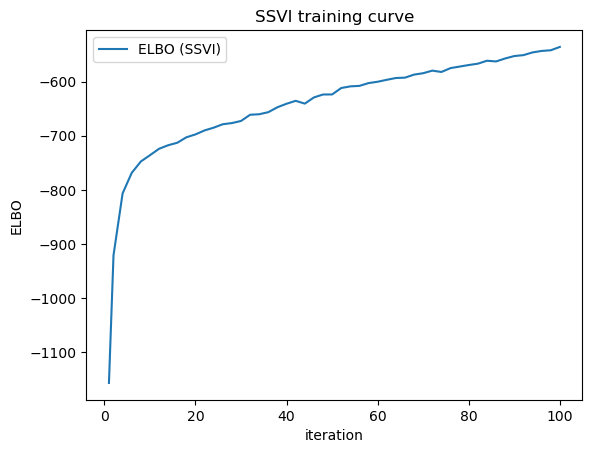

In [28]:
import matplotlib.pyplot as plt

iters = results["elbo_iters"]    # list saved by the trainer
elbo  = results["elbo_vals"]     # same as before

plt.plot(iters, elbo, label="ELBO (SSVI)")
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title("SSVI training curve")
plt.legend()
plt.show()

Predict on new points

In [29]:
x_new  = torch.linspace(domain[0], domain[1], 100,
                        dtype=torch.get_default_dtype(), device=model.DEV).view(-1, 1)   # (100,1)
xs_new = x_new.repeat(n_fun, 1)                                           # (100*n_fun, 1)

fun_ids        = torch.unique(fn_torch, sorted=True)                      # (n_fun,)
X_data_fun_new = torch.cat([ torch.full((len(x_new),), fid,
                                        dtype=torch.long, device=model.DEV)
                             for fid in fun_ids ])                        # (100*n_fun,)
fun_nos_new    = X_data_fun_new                                           # alias

H_mean_vect = model.H_mean[fun_nos_new]                # (100*n_fun , Q)
H_var_vect  = model.H_log_s2.exp()[fun_nos_new]        # (100*n_fun , Q)

Xnew_mean = torch.cat([xs_new,                H_mean_vect], dim=1)        # (N*, D_x+Q)
Xnew_var  = torch.cat([torch.zeros_like(xs_new), H_var_vect], dim=1)      # (N*, D_x+Q)

lvm_mu, lvm_sig2 = model.predict_y((Xnew_mean, Xnew_var))                # (N*, D_out) each

Plot the predictions and the latent coordinates

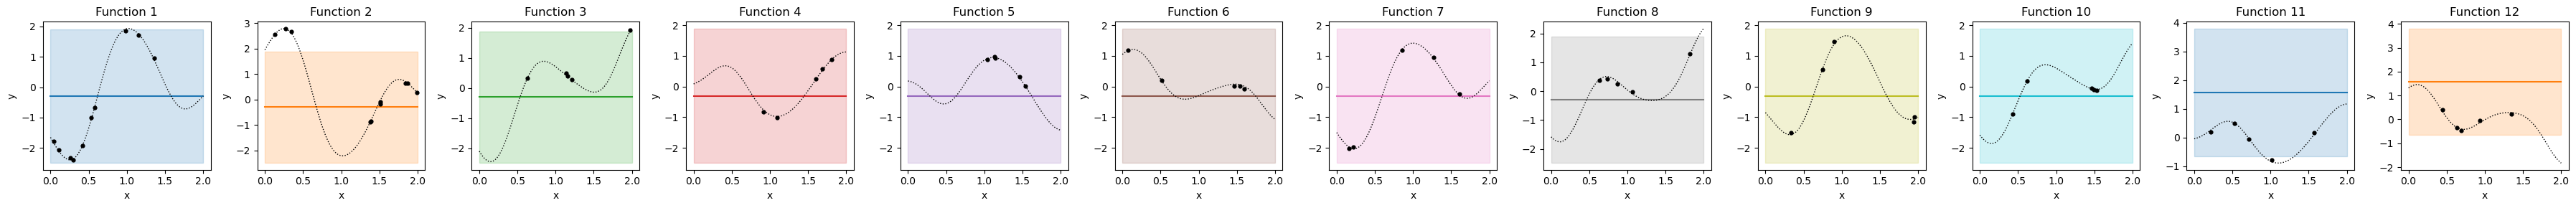

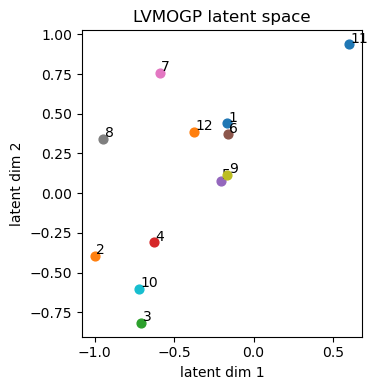

In [30]:
from matplotlib.patches import Ellipse

# SETTINGS  
n_fun        = len(test_fun.functions)          # number of functions
pts_per_fun  = 100                              # x-points per function
palette      = (plt.rcParams['axes.prop_cycle']
                .by_key()['color']) * 10        # plenty of distinct colours

# ---------- 1. Ground-truth curves  -----------------------------------
ys_new = []
for f in test_fun.functions:
    y_tf, _ = f.predict_y(x_new.cpu().numpy())              # GPflow → NumPy
    ys_new.append(torch.from_numpy(y_tf.numpy())            # NumPy → Torch
                       .to(dtype=x_new.dtype,
                           device=x_new.device))

# ---------- 2. LVMOGP predictions vs. ground-truth  -------------------
fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
axs      = axs.flatten()

x_np   = x_new.cpu().numpy().flatten()                      # (100,)
mu_np  = lvm_mu .cpu().numpy().squeeze()                    # (n_fun*100,)
s2_np  = lvm_sig2.cpu().numpy().squeeze()                   # (n_fun*100,)

mu_np = mu_np.reshape(n_fun, pts_per_fun)                   # (n_fun,100)
s2_np = s2_np.reshape(n_fun, pts_per_fun)

for i in range(n_fun):
    mu_i, s2_i = mu_np[i], s2_np[i]

    axs[i].plot(x_np, mu_i, color=palette[i], lw=1.5)       # prediction
    axs[i].fill_between(x_np,                               # 95 % CI
                        mu_i + 2.0*np.sqrt(s2_i),
                        mu_i - 2.0*np.sqrt(s2_i),
                        alpha=0.20, color=palette[i])

    axs[i].scatter(test_fun.xs[i][:n_points[i]],            # training pts
                   test_fun.ys[i][:n_points[i]],
                   color='k', s=12, zorder=3)

    axs[i].plot(x_np,                                       # ground-truth
                ys_new[i].cpu().numpy().flatten(),
                linestyle=':', color='k', lw=1)

    axs[i].set_title(f'Function {i+1}')
    axs[i].set_xlabel('x');  axs[i].set_ylabel('y')

plt.tight_layout();  plt.show()

# ---------- 3. Latent space (Q = 2)  ----------------------------------
fig, axH = plt.subplots(figsize=(4, 4))

H_mean_np = model.H_mean   .cpu().numpy()        # (N_train,2)
H_var_np  = model.H_log_s2.exp().cpu().numpy()   # (N_train,2)
fn_idx_np = model.fn_idx    .cpu().numpy().astype(int)

# choose one training point per function for clarity
rep_idx    = [np.where(fn_idx_np == i)[0][0] for i in range(n_fun)]
H_mean_fun = H_mean_np[rep_idx]                 # (n_fun,2)
H_var_fun  = H_var_np [rep_idx]                 # (n_fun,2)

for i, (m, v) in enumerate(zip(H_mean_fun, H_var_fun)):
    axH.scatter(*m, color=palette[i], s=40, zorder=3)
    axH.annotate(str(i+1), m + 0.01)

    # axis-aligned 95 % ellipse  (around 1.95 sigma)
    ell = Ellipse(xy=m,
                  width  = 1.95*np.sqrt(v[0]),
                  height = 1.95*np.sqrt(v[1]),
                  angle  = 0,
                  alpha  = 0.30,
                  color  = palette[i])
    axH.add_patch(ell)

axH.set_title('LVMOGP latent space')
axH.set_xlabel('latent dim 1');  axH.set_ylabel('latent dim 2')
axH.set_aspect('equal', adjustable='box')
plt.tight_layout();  plt.show()
